# AiiDA's QueryBuilder

*Import statements - make sure to execute the cell below this one (it may be hidden)*

In [118]:
from IPython.display import Image
from datetime import datetime, timedelta
import numpy as np
from aiida import load_dbenv, is_dbenv_loaded
from matplotlib import gridspec, pyplot as plt
if not is_dbenv_loaded():
    load_dbenv()
from aiida.orm import load_node, Node, Group, Computer, User
from aiida.orm import CalculationFactory, DataFactory
from aiida.orm.calculation.job import JobCalculation

PwCalculation = CalculationFactory('quantumespresso.pw')
StructureData = DataFactory('structure')
KpointsData = DataFactory('array.kpoints')
ParameterData = DataFactory('parameter')
UpfData = DataFactory('upf')

We define 2 functions in the following, for visualizations.

In [121]:
def plot_results(query_res):
    """
    :param query_res: The result of an instance of the QueryBuilder
    """
    smearing_unit_set,magnetization_unit_set,pseudo_family_set = set(), set(), set()
    # Storing results:
    results_dict = {}
    for pseudo_family, formula, smearing, smearing_units, mag, mag_units in query_res:
        if formula not in results_dict:
            results_dict[formula] = {}
        # Storing the results:
        results_dict[formula][pseudo_family] = (smearing, mag)
        # Adding to the unit set:
        smearing_unit_set.add(smearing_units)
        magnetization_unit_set.add(mag_units)
        pseudo_family_set.add(pseudo_family)

    # Sorting by formula:
    sorted_results = sorted(results_dict.items())
    formula_list = zip(*sorted_results)[0]
    nr_of_results = len(formula_list)

    # Checks that I have not more than 3 pseudo families.
    # If more are needed, define more colors
    #pseudo_list = list(pseudo_family_set)
    if len(pseudo_family_set) > 3:
        raise Exception('I was expecting 3 or less pseudo families')

    colors = ['b', 'r', 'g']

    # Plotting:
    plt.clf()
    fig=plt.figure(figsize=(16, 9), facecolor='w', edgecolor=None)
    gs  = gridspec.GridSpec(2,1, hspace=0.01, left=0.1, right=0.94)

    # Defining barwidth
    barwidth = 1. / (len(pseudo_family_set)+1)
    offset = [-0.5+(0.5+n)*barwidth for n in range(len(pseudo_family_set))]
    # Axing labels with units:
    yaxis = ("Smearing energy [{}]".format(smearing_unit_set.pop()),
        "Total magnetization [{}]".format(magnetization_unit_set.pop()))
    # If more than one unit was specified, I will exit:
    if smearing_unit_set:
        raise Exception('Found different units for smearing')
    if magnetization_unit_set:
        raise Exception('Found different units for magnetization')
    
    # Making two plots, upper for the smearing, the lower for magnetization
    for index in range(2):
        ax=fig.add_subplot(gs[index])
        for i,pseudo_family in enumerate(pseudo_family_set):
            X = np.arange(nr_of_results)+offset[i]
            Y = np.array([thisres[1][pseudo_family][index] for thisres in sorted_results])
            ax.bar(X, Y,  width=0.2, facecolor=colors[i], edgecolor=colors[i], label=pseudo_family)
        ax.set_ylabel(yaxis[index], fontsize=14, labelpad=15*index+5)
        ax.set_xlim(-0.5, nr_of_results-0.5)
        ax.set_xticks(np.arange(nr_of_results))
        if index == 0:
            plt.setp(ax.get_yticklabels()[0], visible=False)
            ax.xaxis.tick_top()
            ax.legend(loc=3, prop={'size': 18})
        else:
            plt.setp(ax.get_yticklabels()[-1], visible=False)
        for i in range(0, nr_of_results, 2):
            ax.axvspan(i-0.5, i+0.5, facecolor='y', alpha=0.2)
        ax.set_xticklabels(list(formula_list),rotation=90, size=14, ha='center')
    plt.show()

def generate_query_graph(qh, out_file_name):

    def draw_vertice_settings(idx, vertice, **kwargs):
        """
        Returns a string with all infos needed in a .dot file  to define a node of a graph.
        :param node:
        :param kwargs: Additional key-value pairs to be added to the returned string
        :return: a string
        """
        if 'calculation' in vertice['type']:
            shape = "shape=polygon,sides=4"
        elif 'code' in vertice['type']:
            shape = "shape=diamond"
        else:
            shape = "shape=ellipse"
        filters = kwargs.pop('filters', None)
        additional_string = ""
        if filters:
            additional_string += '\nFilters:'
            for k,v in filters.items():
                additional_string += "\n   {} : {}".format(k,v)


        label_string = " ('{}')".format(vertice['tag'])

        labelstring = 'label="{} {}{}"'.format(
            vertice['type'], #.split('.')[-2] or 'Node',
            label_string,
            additional_string)
        #~ return "N{} [{},{}{}];".format(idx, shape, labelstring,
        return "{} [{},{}];".format(vertice['tag'], shape, labelstring)
    nodes = {v['tag']:draw_vertice_settings(idx, v, filters=qh['filters'][v['tag']]) for idx, v in enumerate(qh['path'])}
    links = [(v['tag'], v['joining_value'], v['joining_keyword']) for v in qh['path'][1:]]

    with open('temp.dot','w') as fout:
        fout.write("digraph G {\n")
        for l in links:
            fout.write('    {} -> {} [label=" {}"];\n'.format(*l))
        for _, n_values in nodes.items():
            fout.write("    {}\n".format(n_values))

        fout.write("}\n")
    import os
    os.system('dot temp.dot -Tpng -o {}'.format(out_file_name))

def store_formula_in_extra():
    qb = QueryBuilder()
    qb.append(StructureData, filters={'extras':{'!has_key':'formula'}})
    for structure, in qb.all():
        structure.set_extra('formula', structure.get_formula(mode='count'))
store_formula_in_extra()

### 1. Introduction to the QueryBuilder
As you will use `AiiDA` to run your calculations, the database that stores all the data and the provenance, will quickly grow to be very large. So in order to find a needle that we might be looking for in this big haystack, we need an efficient excavation and search tool. The tool that `AiiDA` provides to do exactly this is called the `QueryBuilder`. The `QueryBuilder` acts as the gatekeeper to your database, that you can ask questions about the contents of your database (also referred to as queries), by specifying what it is that you are looking for. In this part of the tutorial, we will focus on how to use the `QueryBuilder` to make these queries and understand/use the results.

In order to use the `QueryBuilder`, we first need to import it. We can accomplish this by executing the `import` statement in the following cell. Go ahead and select the next cell, and press `Shift+Enter`.

In [87]:
from aiida.orm.querybuilder import QueryBuilder

Before we can ask the `QueryBuilder` questions about our database, we first need to create an instance of it:

In [88]:
qb = QueryBuilder()

Now that we have an instance of our `QueryBuilder` which we named `qb`, we are ready to start asking it about the contents of our database. For example, we may want to know exactly how many nodes there are in our database. To tell `qb` that we are interested in all the occurrences of the `Node` class in our database, we `append` it to the list of objects it should find.

In [89]:
qb.append(Node)

We have now narrowed down the scope of `qb` to just the nodes that are present in our database. To learn how many nodes there are exactly, all we have to do is to ask `qb` to count them.

In [90]:
qb.count()

4680L

Now as you may have learned in previous sections of the tutorial, nodes come in different kinds and flavors. For example, all our crystal structures that we have stored in the database, are saved in a node that is of the type `StructureData`. If instead of all the nodes, rather we would like to count only the structure nodes, we simply tell our `QueryBuilder` to narrow its scope to only objects of the `StructureData` type. Since we are creating a new query, we have to create a new instance of the `QueryBuilder`. In the next cell, we have typed part of the code to count all the structure nodes. See if you can finish the line with the comment, to tell the `QueryBuilder` that you are only interested in `StructureData` nodes.

In [91]:
qb = QueryBuilder()
qb.append(StructureData) # How do we finish this line to tell the query builder to count only the structure nodes?
qb.count()

615L

Instead of just counting how many structure nodes we have, we may also actually want to see some of them. This is as easy as telling our `QueryBuilder` that we are not interested in the `count` but rather that we want to retrieve `all` the nodes.

In [92]:
qb = QueryBuilder()
qb.append(StructureData)
qb.all()

[[<StructureData: uuid: 8d2d2f0f-cf14-4247-be13-6136ca84d770 (pk: 2)>],
 [<StructureData: uuid: e97bcfe6-0312-4b6f-bdc4-62cbedfab119 (pk: 7)>],
 [<StructureData: uuid: 11a13eb6-0579-4729-90d9-c06dd143532e (pk: 21)>],
 [<StructureData: uuid: bf09f554-624f-4525-bdf3-52b8ec802940 (pk: 26)>],
 [<StructureData: uuid: 4909f51c-e037-4ba1-9b8f-0e8f7477b5ef (pk: 27)>],
 [<StructureData: uuid: b69afaa9-761e-4377-ae77-f952a60a8887 (pk: 28)>],
 [<StructureData: uuid: efe1b5c8-4aec-4738-ba86-707096a576af (pk: 39)>],
 [<StructureData: uuid: 0396bc2b-7bd9-4a0b-a70a-5b0bcc323ae6 (pk: 52)>],
 [<StructureData: uuid: 1eefd0f6-d7d9-4681-bae8-d882cb3e4340 (pk: 58)>],
 [<StructureData: uuid: df873b09-312f-45e7-88aa-0d3f3a4e7d01 (pk: 65)>],
 [<StructureData: uuid: 9c6807c1-5f1c-49fd-a52e-ccd3e53d3d86 (pk: 74)>],
 [<StructureData: uuid: a2ae295e-c7c6-43f3-8b2c-597104a8b440 (pk: 77)>],
 [<StructureData: uuid: 0984bf55-2b57-4590-bce8-ea10fbe75763 (pk: 84)>],
 [<StructureData: uuid: 29bf77e6-1c91-4806-a662-ee74f

Note that this command is very literal and does in fact retrieve **all** the structure nodes that are stored in your database, which may become very slow if your database becomes very large. One solution is to simply tell the `QueryBuilder` that we are for example only interested in 5 structure nodes. This can be done with the `limit` method as follows:

In [93]:
qb = QueryBuilder()
qb.append(StructureData)
qb.limit(5)
qb.all()

[[<StructureData: uuid: 8d2d2f0f-cf14-4247-be13-6136ca84d770 (pk: 2)>],
 [<StructureData: uuid: e97bcfe6-0312-4b6f-bdc4-62cbedfab119 (pk: 7)>],
 [<StructureData: uuid: 11a13eb6-0579-4729-90d9-c06dd143532e (pk: 21)>],
 [<StructureData: uuid: bf09f554-624f-4525-bdf3-52b8ec802940 (pk: 26)>],
 [<StructureData: uuid: 4909f51c-e037-4ba1-9b8f-0e8f7477b5ef (pk: 27)>]]

Another option is to simply use the concept of array slicing, native to python, to specify a subset of the total return set to be returned

In [94]:
qb.limit(None)
qb.all()[:7]

[[<StructureData: uuid: 8d2d2f0f-cf14-4247-be13-6136ca84d770 (pk: 2)>],
 [<StructureData: uuid: e97bcfe6-0312-4b6f-bdc4-62cbedfab119 (pk: 7)>],
 [<StructureData: uuid: 11a13eb6-0579-4729-90d9-c06dd143532e (pk: 21)>],
 [<StructureData: uuid: bf09f554-624f-4525-bdf3-52b8ec802940 (pk: 26)>],
 [<StructureData: uuid: 4909f51c-e037-4ba1-9b8f-0e8f7477b5ef (pk: 27)>],
 [<StructureData: uuid: b69afaa9-761e-4377-ae77-f952a60a8887 (pk: 28)>],
 [<StructureData: uuid: efe1b5c8-4aec-4738-ba86-707096a576af (pk: 39)>]]

If we want to know a little bit more about the retrieved structure nodes, we can ask the `QueryBuilder` to return an iterator which we can then use in a straightforward `for`-loop. This allows one for example to print the formula of the structures

In [95]:
qb = QueryBuilder()
qb.append(StructureData)
qb.limit(5)
for structure, in qb.iterall():
    print structure.get_formula()

O3SrZr
BaO3Zr
CsNbO3
O3PbZr
NbO3Rb


This is just a simple example how we can employ the `QueryBuilder` to get details about the contents of our database. We have now seen simple queries for the `Node` and `StructureData` classes of nodes, but the same rules apply to all the `AiiDA` node classes. For example we may want to count the number of entries for each of the node classes in the following list

In [96]:
class_list = [Node, StructureData, KpointsData, ParameterData, UpfData]

Using the tools we have learned so far, we can build a table of the number of occurrences of each of these node classes that are stored in our database. We simply loop over the `class_list` and create a `QueryBuilder` for each and count the entries.

In [97]:
for class_name in class_list:
    qb = QueryBuilder()
    qb.append(class_name)
    print '{:>15} | {:6}'.format(class_name.__name__, qb.count())

           Node |   4680
  StructureData |    615
    KpointsData |    857
  ParameterData |   1332
        UpfData |     99


If all went well, you should see something like the following, where of course the numbers may differ for your database

Class name     | Entries
---------------|--------
 Node          | 10273 
 StructureData | 271   
 KpointsData   | 953   
 ParameterData | 2922  
 UpfData       | 85    

### 2. Projection and filters
Up till now we have always asked the `QueryBuilder` to return the entire node, of whatever class of nodes that we specified. However, we might not necessarily be interested in all the node's properties, but rather just a select set or even just a single property. We can tell the `QueryBuilder` which properties we would like returned, by asking it to **project** those properties in the result. For example, we may only want to get the uuid's of a set of nodes. 

In [98]:
qb = QueryBuilder()
qb.append(Node, project=['uuid'])
qb.limit(5)
qb.all()

[[u'de87cc13-d394-42b1-b1e2-d7431f55e6bf'],
 [u'8d2d2f0f-cf14-4247-be13-6136ca84d770'],
 [u'4a0a265a-02d1-46b5-8dad-599846949021'],
 [u'a7a17027-b3c4-45bb-a556-add9d1f2559e'],
 [u'79963006-b6e7-489d-a969-0c65cd6c4d99']]

We inform the `QueryBuilder` that we are only interested in the `uuid` property of the `Node` class by specifing the `project` keyword in the `append` call. Note that the value that we assign to `project` is a list, as we may want to specify more than one property. See if you can get the `QueryBuilder` to return *both* the `id` and the `uuid` of the first 5 `Node`'s in the following cell.

In [99]:
qb = QueryBuilder()
qb.append(Node, project=['id', 'uuid'])#? What should the value be for the project key
qb.limit(5)
qb.all()

[[1, u'de87cc13-d394-42b1-b1e2-d7431f55e6bf'],
 [2, u'8d2d2f0f-cf14-4247-be13-6136ca84d770'],
 [3, u'4a0a265a-02d1-46b5-8dad-599846949021'],
 [4, u'a7a17027-b3c4-45bb-a556-add9d1f2559e'],
 [5, u'79963006-b6e7-489d-a969-0c65cd6c4d99']]

To give you an idea of the various properties that you can project for some of the `AiiDA` node classes you can consult the following table.
Note that this is by no means an exhaustive list

Class    | Properties
---------|-----------
Node     | `id`, `uuid`, `type`, `label`, `description`, `ctime`, `mtime`
Computer | `id`, `uuid`, `name`, `hostname`, `description`, `enabled`, `transport_type`, `scheduler_type`
User     | `id`, `email`, `first_name`, `last_name`, `institution`
Group    | `id`, `uuid`, `name`, `type`, `time`, `description`

The same properties can also be used to *filter* for specific nodes in your database. Up till now, we only ever asked to return the `QueryBuilder` all the instances of a certain type of node, or at best a limited number of those. But we might be interested in a very specific node. For example, we may have the `id` of a certain node and we would like to know when it was created and last modified. We can tell the `QueryBuilder` to select nodes that only match that criterion, by telling it to **filter** based on that property.

In [100]:
qb = QueryBuilder()
qb.append(Node, project=['ctime', 'mtime'], filters={'id': {'==': 1}})
qb.all()

[[datetime.datetime(2014, 10, 27, 18, 8, 41, 829229, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),
  datetime.datetime(2017, 5, 12, 11, 39, 55, 896083, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None))]]

Note the syntax of the `filters` keyword. The value is a dictionary, where the keys indicate the node property that it is supposed to operate on, in this case the `id` property. The value of that key is again itself a dictionary, where the key indicates the logical operator `==` and the value corresponds to the value of the property.

You may have multiple criteria that you want to filter for, in which case you can use the logical `or` and `and` operators. Let's say, for example, that you want the `QueryBuilder` to retrieve all the `StructureData` nodes that have a certain `label` **and** where created no longer than 10 days ago. You can translate this criterion by making use of the `and` operator which allows you to specify multiple filters that all have to be satisfied.

In [101]:
qb = QueryBuilder()
qb.append(
    Node, 
    filters={
        'and': [
            {'ctime': {'>': datetime.now() - timedelta(days=12)}},
            {'label': 'graphene'}
        ]
    }
)
qb.all()

[]

You will have noticed that the `>` operator, and its related operators, can work with python `datetime` objects. These are just a few of the operators that `QueryBuilder` understands. Below you find a table with the various logical operators that you can use

Operator             | Data type             | Example                            | Description
---------------------|-----------------------|------------------------------------|------------------
`==`                 | all                   | `{'==': '12'}`                     | equality operator
`in`                 | all                   | `{'in':['FINISHED', 'PARSING']}`   | member of a set
`<`, `>`, `<=`, `>=` | float, int, datetime  | `{'>': 5.2}`                       | size comparison operator
`like`               | char, str             | `{'like': 'calculation%'}`         | string comparison, `%` is wildcard
`ilike`              | char, str             | `{'ilike': 'caLCulAtion%'}`        | string comparison, capital insensitive
`or`                 |                       | `{'or': [{'<': 5.3}, {'>': 6.3}]}` | logical or operator
`and`                |                       | `{'and': [{'>=': 2}, {'<=': 6}]}`  | logical and operator

As an exercise, try to write a query below that will retrieve all `Group` nodes whose `name` property starts with the string `tutorial`.

In [102]:
# Write your query here
qb = QueryBuilder()
qb.append(Group, filters={'name': {'like': 'tutorial%'}})
qb.limit(5)
qb.all()

[[<Group: "tutorial_lda" [user-defined], of user nicolas.mounet@epfl.ch>],
 [<Group: "tutorial_pbe" [user-defined], of user nicolas.mounet@epfl.ch>],
 [<Group: "tutorial_pbesol" [user-defined], of user nicolas.mounet@epfl.ch>]]

### 3. Defining relationships between query clauses

So far we have seen how we can use the `QueryBuilder` to search the database for entries of a specific node type, potentially projecting only specific properties and filtering for certain property values. However, our nodes do not live in a vacuum, but they are often related to one another. Especially, there will be interesting relationships between different types of nodes. Therefore we would like to be able to search for nodes, based on a certain relationship that they might have with other nodes. Consider for example that you have a `StructureData` node that was produced by some calculation. How would we be able to retrieve that calculation?

To accomplish this, we need to be able to tell the `QueryBuilder` what the relationship is between the nodes that we are interested in. If we take the example of the structure node but abstracting it to all structure nodes, we could do the following to find all the structure nodes that were generated as an output by a `PwCalculation` node.

In [103]:
qb = QueryBuilder()
qb.append(PwCalculation, tag='calculation')

We are looking for descendants of `PwCalculation` nodes, so we `append` it to a `QueryBuilder` instance. In the future, we need to be able to reference to this clause and therefore we give it a name or `tag` it with the `tag` keyword.

In [104]:
qb.append(StructureData, output_of='calculation')

The goal was to find `StructureData` nodes, so we `append` that to the `qb`. However, we didn't want to find just any `StructureData` nodes; they had to be an output of `PwCalculation`. Note how we expressed this relation by the `output_of` keyword and using the `tag` name `calculation` that we had just assigned in the previous `append` statement.
Now all we have to do is execute the query to retrieve our structures:

In [105]:
qb.limit(5)
qb.all()

[[<StructureData: uuid: 78abbcb4-7bba-4805-a008-deaa6da59c6c (pk: 782)>],
 [<StructureData: uuid: d20f8cc9-cd10-4b00-b399-574268bb976c (pk: 3201)>],
 [<StructureData: uuid: e4cdeca6-cc4e-4bf6-b005-1b050f80e0af (pk: 423)>],
 [<StructureData: uuid: 7ec775bf-67b6-4808-93f6-4922d7b08faa (pk: 486)>],
 [<StructureData: uuid: 88682e49-ba33-4ab3-a3d6-1d075501ab5e (pk: 1458)>]]

What we did can be visualized schematically.

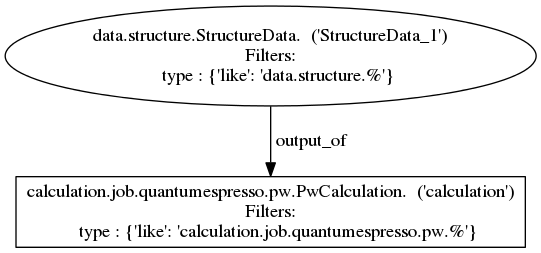

In [106]:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query1.png')
Image(filename='query1.png')

The `output_of` keyword is but one of many potential relationships that exist between the various `AiiDA` nodes, that are implemented in the `QueryBuilder`. The table below gives an overview of the implemented relationships, which nodes they are defined for and which relation it implicates.

Entity from	| Entity to	| Relationship  | Explanation
------------|-----------|---------------|------------
Node        | Node      | input_of      | One node as input of another node
Node        | Node      | output_of     | One node as output of another node
Node        | Node      | ancestor_of   | One node as the ancestor of another node
Node        | Node      | descendant_of | One node as descendant of another node
Group       | Node      | group_of      | The group of a node
Node        | Group     | member_of     | The node is a member of a group
Computer    | Node      | computer_of   | The computer of a node
Node        | Computer  | has_computer  | The node of a computer
User        | Node      | creator_of    | The creator of a node is a user
Node        | User      | created_by    | The node was created by a user

As an exercise, see if you can write a query that will return all the `UpfData` nodes that are a member of a `Group` whose name starts with the string `SSSP`.

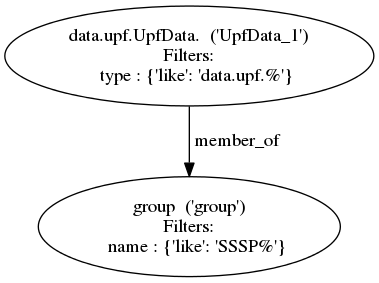

In [107]:
qb = QueryBuilder()
qb.append(Group, filters={'name': {'like': 'SSSP%'}}, tag='group')
qb.append(UpfData, member_of='group')
qb.all()[:5]
# Here I also visualize what's going on:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query2.png')
Image(filename='query2.png')

### 4. Attributes and extras

In section 2, we showed you how you can `project` specific properties of a `Node` and gave a list of properties that a `Node` instance possesses. Since then, we have come across a lot of different `AiiDA` data nodes, such as `StructureData` and `UpfData`, that were secretly `Node`'s in disguise. Or to put it correctly, as `AiiDA` employs the object-oriented programming paradigm, both `StructureData` and `UpfData` are examples of subclasses of the `Node` class and therefore inherit its properties. That means that whatever property a `Node` has, both `StructureData` and `UpfData` will have too. However, there is a semantic difference between a `StructureData` node and a `UpfData`, and so we may want to add a property to one that would not make sense for the other. To solve this, `AiiDA` introduces the concept of `attributes`. These are similar to properties, except that they are specific to the `Node` type that they are attached to. This allows you to add an `attribute` to a certain node, without having to change the implementation of all the others.

For example, the `ParameterData` nodes that are generated as output of `PwCalculation`'s may have an attribute named `wfc_cutoff`. To project for this particular `attribute`, one can use exactly the same syntax as shown in section 2 for the regular `Node` properties, and one has to only prepend `attributes.` to the attribute name. Demonstration:

In [108]:
qb = QueryBuilder()
qb.append(PwCalculation, tag='pw')
qb.append(ParameterData, output_of='pw', project=["attributes.wfc_cutoff"])
qb.limit(5)
qb.all()

[[816.341503518],
 [816.341503518],
 [816.341503518],
 [816.341503518],
 [816.341503518]]

Note that not every `ParameterData` node has to have this attribute, in which case the `QueryBuilder` will return the python keyword `None`. Similar to the `attributes`, nodes also can have `extras`, which work in the same way, except that `extras` are mutable, which means that their value can be changed even after a node instance has been stored.

If you are not sure which attributes a given node has, you can use the `get_attrs()` method to simply retrieve them all. It will return a dictionary with all the attributes the node has.

In [109]:
qb = QueryBuilder()
qb.append(PwCalculation)
node, = qb.first()
node.get_attrs()

{u'custom_scheduler_commands': u'#SBATCH --account=ch3',
 u'job_id': u'461976',
 u'jobresource_params': {u'default_mpiprocs_per_machine': 8,
  u'num_machines': 1,
  u'num_mpiprocs_per_machine': 8},
 u'last_jobinfo': u'{"job_id": "461976", "wallclock_time_seconds": 778, "title": "aiida-39102", "num_machines": 1, "job_state": "RUNNING", "queue_name": "normal", "num_mpiprocs": 8, "allocated_machines_raw": "nid02504", "submission_time": {"date": "2014-10-28T19:38:24.000000", "timezone": null}, "job_owner": "mounet", "detailedJobinfo": "Detailed jobinfo obtained with command \'sacct --format=AllocCPUS,Account,AssocID,AveCPU,AvePages,AveRSS,AveVMSize,Cluster,Comment,CPUTime,CPUTimeRAW,DerivedExitCode,Elapsed,Eligible,End,ExitCode,GID,Group,JobID,JobName,MaxRSS,MaxRSSNode,MaxRSSTask,MaxVMSize,MaxVMSizeNode,MaxVMSizeTask,MinCPU,MinCPUNode,MinCPUTask,NCPUS,NNodes,NodeList,NTasks,Priority,Partition,QOSRAW,ReqCPUS,Reserved,ResvCPU,ResvCPURAW,Start,State,Submit,Suspended,SystemCPU,Timelimit,TotalC

The element type symbol of a pseudopotential, that is represented by a `UpfData` node, is stored in the `element` attribute. Using the knowledge that filtering on attributes works exactly as for normal node properties, see if you can write a query that will search your database for pseudopotentials for silicon.

In [110]:
qb = QueryBuilder()
qb.append(UpfData, filters={'attributes.element': {'==': 'Si'}})
qb.all()

[[<UpfData: uuid: 59814d74-4d3a-43ee-8a2a-22b7f88b9594 (pk: 848)>],
 [<UpfData: uuid: 1f425b53-cb9d-4988-b2d2-5e51a7e80582 (pk: 2014)>],
 [<UpfData: uuid: 8371ee69-3f83-45b5-845e-73ae833d1169 (pk: 4140)>]]

### 5. A small high-through study

In this part of the tutorial, we will focus on how to systematically retrieve, query and analyze the results of
multiple calculations using AiiDA. We know you’re able to do this yourself, but to save time, a set of calculations
have already been done with AiiDA for you on 57 perovskites, using three different pseudopotential families (LDA,
PBE and PBESOL, all from GBRV 1.2). These calculations are spin-polarized (without spin-orbit coupling), use a Gaussian smearing and perform a variable-cell relaxation of the full unit cell. The idea of this part of the tutorial is to “screen” for magnetic and metallic perovskites in a “high-throughput” way. As you learned in the first part of the tutorial, AiiDA allows to organize calculations in groups. Once more check the list of groups in your database by typing:

In [111]:
!verdi group list -A

  PK  GroupName          NumNodes  User
----  ---------------  ----------  ----------------------
   1  tutorial_pbesol          57  nicolas.mounet@epfl.ch
   2  tutorial_lda             57  nicolas.mounet@epfl.ch
   3  tutorial_pbe             57  nicolas.mounet@epfl.ch


The calculations needed for this task were put in three different groups whose names start with "tutorial" (one for each pseudopotential family). The main task is to make a plot showing, for all perovskites and for each pseudopotential family, the total magnetization and the −T S contribution from the smearing to the total energy.

#### Start building the query
So we first of all need to instantiate a QueryBuilder instance and filter by the right name:

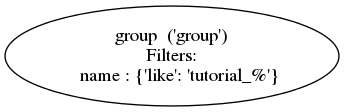

In [112]:
# Instantiating QB:
qb = QueryBuilder()
# Appending the groups I care about:
qb.append(Group, filters={'name':{'like':'tutorial_%'}}, project='name', tag='group')
# Visualize:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query3.png')
Image(filename='query3.png')

#### Append the calculations that are members of each group

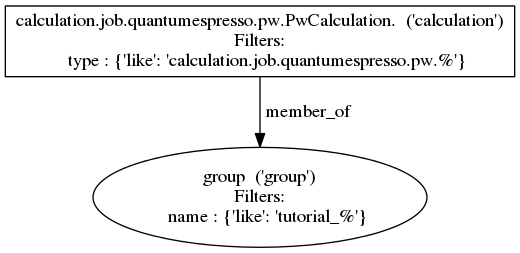

In [113]:
# I want every PwCalculation that is a member of the specified groups:
qb.append(PwCalculation, tag='calculation', member_of='group')
#Visualize
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query4.png') 
Image(filename='query4.png')

#### Append the structures that are input of the calculation. Project the formula, stored in the extras under the key 'formula'

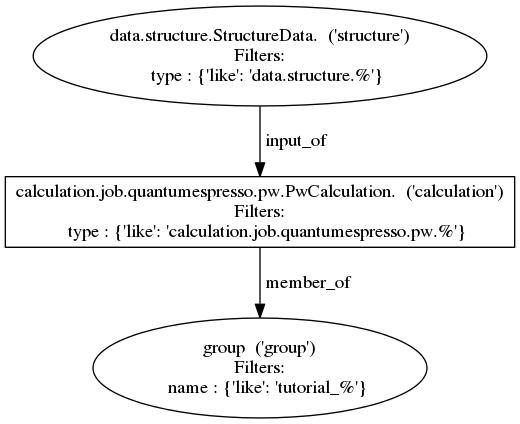

In [114]:
qb.append(StructureData, project=['extras.formula'], tag='structure', input_of='calculation')
# Visualize:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query5.png')
Image(filename='query5.png')

Append the parameters that are an output of the calculation.

Project:
* The smearing contribution and the units
* The magnetization and the untits.

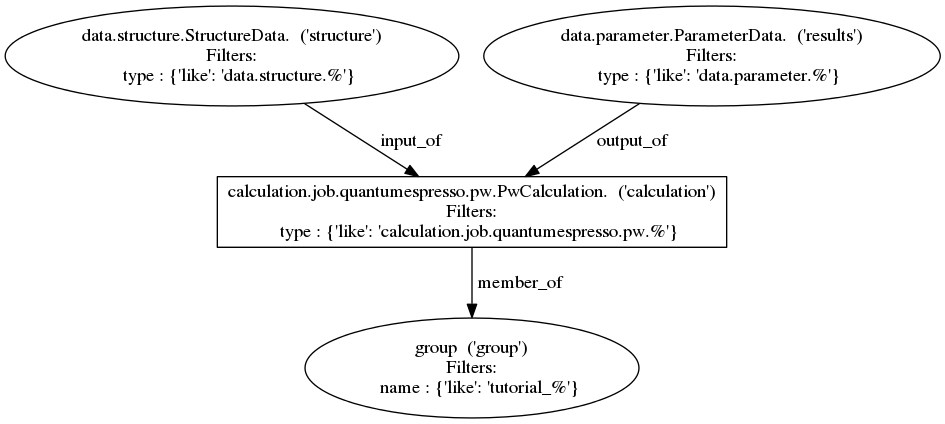

In [115]:
qb.append(ParameterData,tag='results',
        project=['attributes.energy_smearing', 'attributes.energy_smearing_units',
           'attributes.total_magnetization', 'attributes.total_magnetization_units',
        ], output_of='calculation'
    )
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query6.png') 
Image(filename='query6.png')

#### Print the query results

In [123]:
results = qb.all()
for item in results:
    print ', '.join(map(str, item))

tutorial_lda, SrTiO3, -1.36056917253e-07, eV, 0.0, Bohrmag / cell
tutorial_lda, RbNbO3, -7.48313044891e-06, eV, 0.0, Bohrmag / cell
tutorial_lda, GaTaO3, -0.00150873515542, eV, 0.0, Bohrmag / cell
tutorial_lda, BiScO3, -0.000910220776423, eV, 0.0, Bohrmag / cell
tutorial_lda, SrZrO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_lda, BaSiO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_lda, SrSiO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_lda, AgNbO3, -9.66004112496e-06, eV, 0.0, Bohrmag / cell
tutorial_lda, PbSiO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_lda, SnZrO3, -2.72113834506e-07, eV, 0.0, Bohrmag / cell
tutorial_lda, CsNbO3, -6.44909787779e-05, eV, 0.0, Bohrmag / cell
tutorial_lda, SnTiO3, -0.000417150508298, eV, 0.0, Bohrmag / cell
tutorial_lda, SrMnO3, -0.0710686504425, eV, 2.87, Bohrmag / cell
tutorial_lda, CaHfO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_lda, BiGaO3, -1.79595130774e-05, eV, 0.0, Bohrmag / cell
tutorial_lda, CuNbO3, -0.00790871648608, eV, 0.0, Bohrmag / cell
tutorial_lda, YAlO3, 0

#### Plot the results
Getting a long list is not always helpful. We prepared a function that visualizes the results of the query:

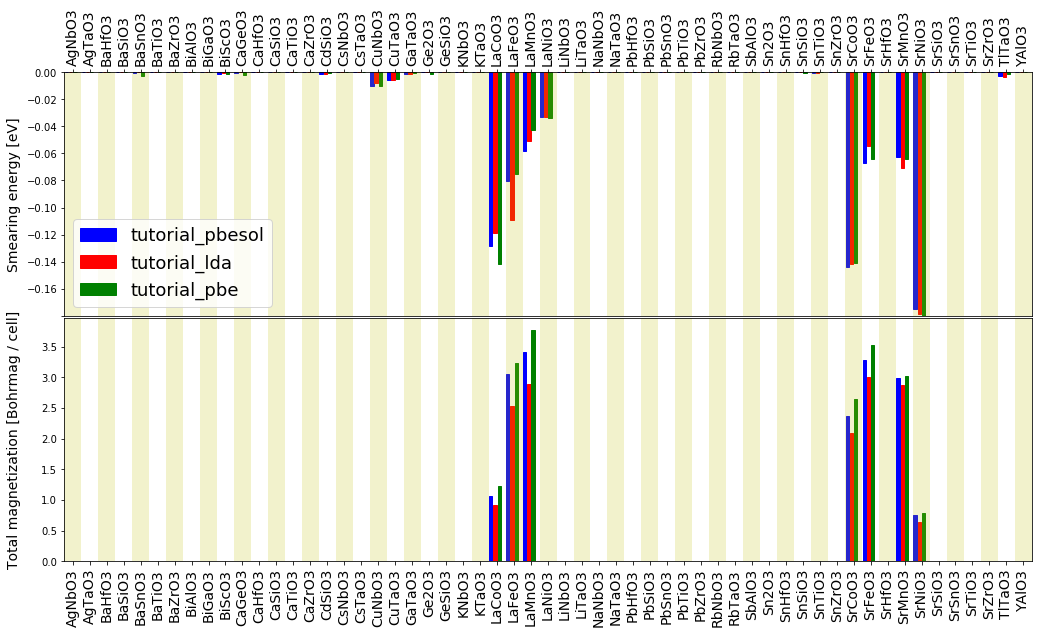

In [124]:
plot_results(results)